In [1]:
# ============================================
# 셀 1: 라이브러리 import 및 기본 설정
# ============================================
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from torchvision import transforms
import timm
import random
from datetime import datetime

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")


c:\Users\pjjeo\anaconda3\envs\calmman-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti
CUDA 버전: 12.8
메모리: 15.9GB


In [2]:

# ============================================
# 셀 2: 모델 클래스 정의
# ============================================
class EfficientNetClassifier(nn.Module):
    """EfficientNet-B0 기반 이진분류 모델"""
    
    def __init__(self, num_classes=2, pretrained=True, dropout_rate=0.3):
        super(EfficientNetClassifier, self).__init__()
        
        # timm에서 EfficientNet-B0 로드
        self.backbone = timm.create_model(
            'efficientnet_b0', 
            pretrained=pretrained,
            num_classes=0,  # 분류 헤드 제거
            drop_rate=dropout_rate
        )
        
        # 특징 차원 얻기
        self.feature_dim = self.backbone.num_features
        
        # 커스텀 분류 헤드
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_classes)
        )
        
    def forward(self, x):
        # 백본을 통과하여 특징 추출
        features = self.backbone(x)
        # 분류 헤드를 통과
        outputs = self.classifier(features)
        return outputs

print("✅ 모델 클래스 정의 완료")


✅ 모델 클래스 정의 완료


In [4]:

# ============================================
# 셀 3: 모델 로드
# ============================================
# 모델 인스턴스 생성
model = EfficientNetClassifier(num_classes=2, pretrained=False)  # pretrained=False로 설정
model = model.to(device)

# 학습된 가중치 로드
model_path = "../results/pytorch_efficientnet/models"  # 모델 디렉토리
if os.path.exists(model_path):
    model_files = [f for f in os.listdir(model_path) if f.endswith('.pth')]
    if model_files:
        # best_model_stage2가 있으면 우선 선택, 없으면 최신 파일
        stage2_models = [f for f in model_files if 'stage2' in f]
        if stage2_models:
            latest_model = sorted(stage2_models)[-1]
        else:
            latest_model = sorted(model_files)[-1]
        
        model_full_path = os.path.join(model_path, latest_model)
        print(f"모델 로드: {model_full_path}")
        model.load_state_dict(torch.load(model_full_path, map_location=device))
    else:
        print("❌ 모델 파일을 찾을 수 없습니다.")
        print(f"경로 확인: {model_path}")
else:
    print(f"❌ 모델 디렉토리가 존재하지 않습니다: {model_path}")
    print("학습을 먼저 실행해주세요.")

model.eval()
print("✅ 모델 로드 완료")


모델 로드: ../results/pytorch_efficientnet/models\best_model_stage2_20250604_105155.pth
✅ 모델 로드 완료


In [6]:

# ============================================
# 셀 4: 전처리 Transform 정의
# ============================================
# 전처리 Transform (학습 시와 동일)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

# 분류 클래스 및 색상 설정
class_names = ['평범한사진', '웃긴사진']
colors = ['blue', 'red']

print("✅ 전처리 Transform 설정 완료")


✅ 전처리 Transform 설정 완료


In [7]:

# ============================================
# 셀 5: 이미지 로드 및 예측 함수
# ============================================
def load_and_predict_single(image_path, model, transform, device):
    """단일 이미지 로드 및 예측"""
    try:
        # 이미지 로드
        if isinstance(image_path, str):
            # 파일 경로인 경우
            img = cv2.imread(image_path)
            if img is None:
                img = np.array(Image.open(image_path))
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            # numpy array인 경우
            img = image_path
            
        # PIL로 변환
        if isinstance(img, np.ndarray):
            img_pil = Image.fromarray(img.astype(np.uint8))
        else:
            img_pil = img
            
        # Transform 적용
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        
        # 예측
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
            
        return img, predicted_class, confidence, probabilities[0].cpu().numpy()
    
    except Exception as e:
        print(f"이미지 처리 오류: {e}")
        return None, None, None, None

def load_and_predict_batch(image_paths, model, transform, device, batch_size=32):
    """배치 이미지 로드 및 예측"""
    results = []
    images = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        batch_original_images = []
        valid_indices = []
        
        # 배치 이미지 로드
        for j, img_path in enumerate(batch_paths):
            try:
                # 이미지 로드
                img = cv2.imread(img_path)
                if img is None:
                    img = np.array(Image.open(img_path))
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # PIL로 변환 및 전처리
                img_pil = Image.fromarray(img.astype(np.uint8))
                img_tensor = transform(img_pil)
                
                batch_images.append(img_tensor)
                batch_original_images.append(img)
                valid_indices.append(j)
                
            except Exception as e:
                print(f"이미지 로드 실패 {img_path}: {e}")
                results.append((None, None, None, None))
                continue
        
        if batch_images:
            # 배치 텐서 생성
            batch_tensor = torch.stack(batch_images).to(device)
            
            # 배치 예측
            with torch.no_grad():
                outputs = model(batch_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_classes = torch.argmax(outputs, dim=1)
                confidences = torch.max(probabilities, dim=1)[0]
            
            # 결과 저장
            for k, valid_idx in enumerate(valid_indices):
                results.append((
                    batch_original_images[k],
                    predicted_classes[k].item(),
                    confidences[k].item(),
                    probabilities[k].cpu().numpy()
                ))
                
    return results

print("✅ 예측 함수 정의 완료")


✅ 예측 함수 정의 완료


✅ 상세 분석 함수 정의 완료
=== 📁 test_image 디렉토리 테스트 (단일 처리) ===
📁 test_image 디렉토리에서 15개 이미지 발견
📷 k13.png: 웃긴사진 (53.6%)
📷 스크린샷 2025-05-30 134634_face7.png: 웃긴사진 (87.2%)
📷 스크린샷 2025-05-30 134634_face3.png: 웃긴사진 (64.7%)
📷 angry_00489_0.907.jpg: 웃긴사진 (85.8%)
📷 h13.png: 웃긴사진 (98.8%)
📷 스크린샷 2025-05-28 154433.png: 웃긴사진 (88.8%)
📷 angry_02594_0.915.jpg: 웃긴사진 (79.0%)
📷 화면 캡처 2025-05-29 103553.png: 웃긴사진 (99.9%)


C:\Users\pjjeo\AppData\Local\Temp\ipykernel_60716\2484445079.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


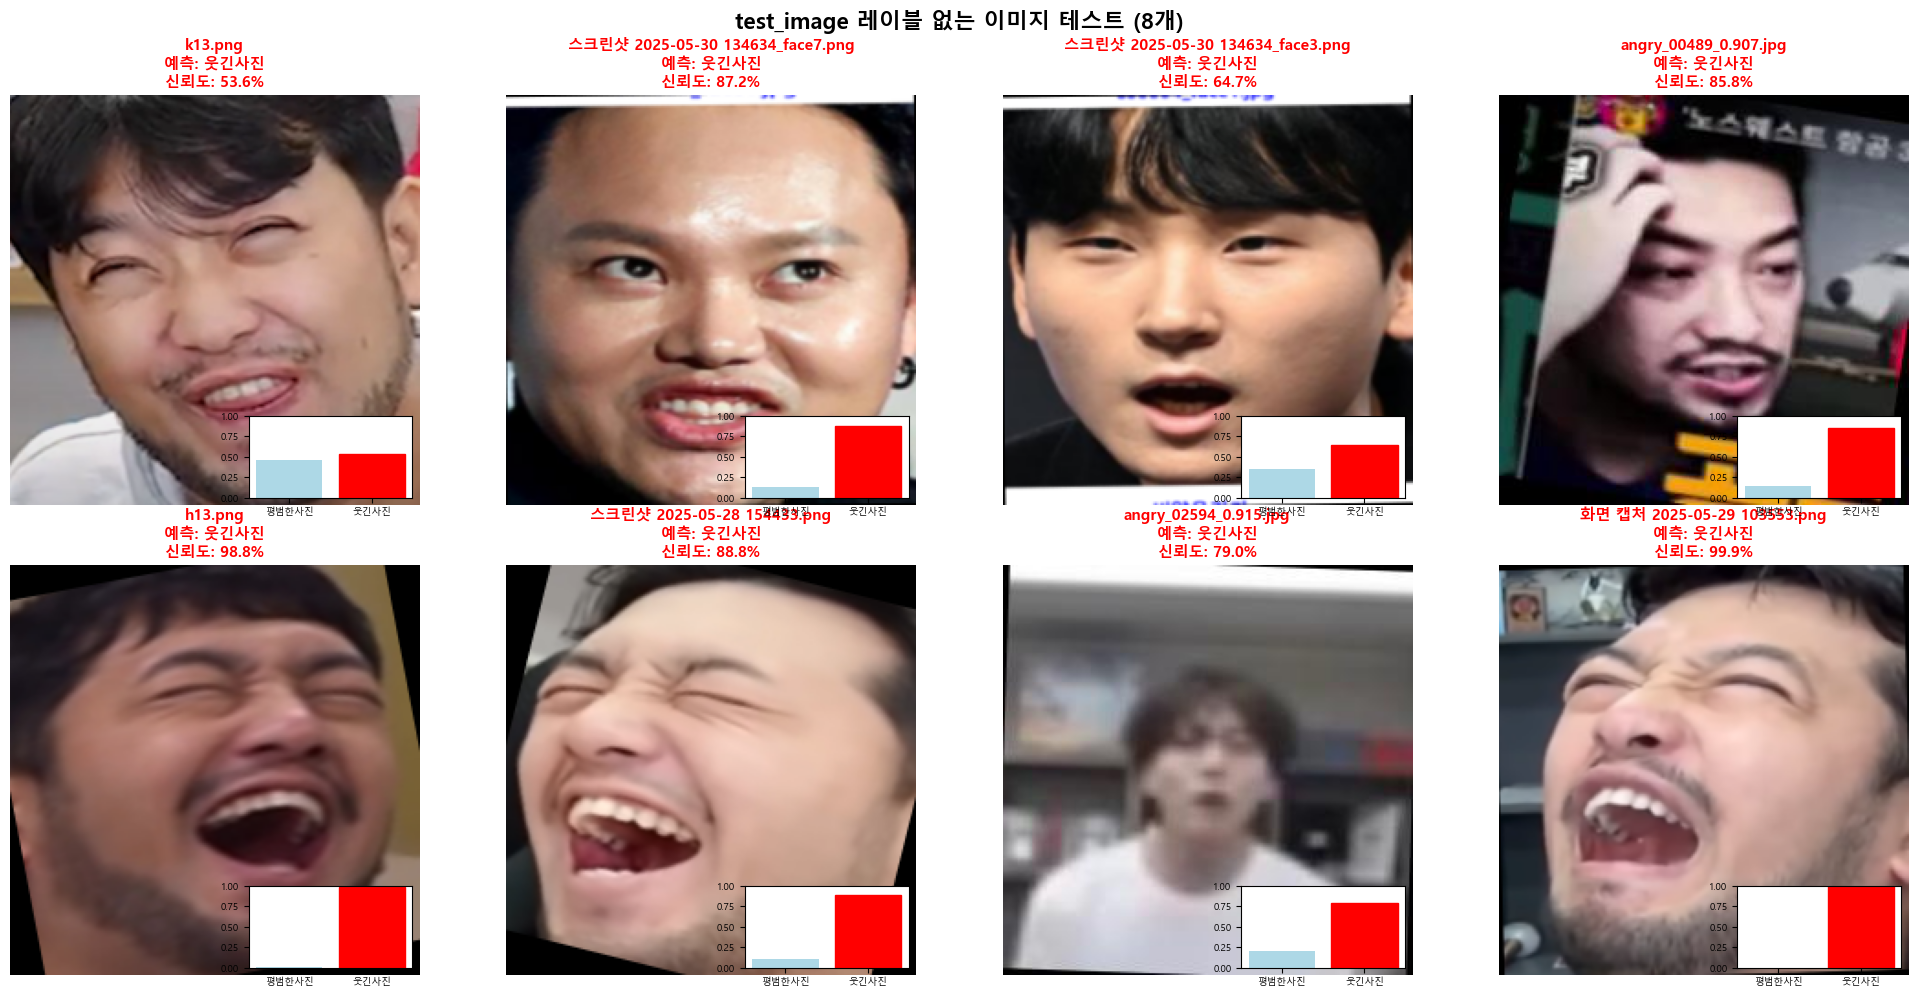


=== 📊 단일 처리 결과 요약 ===
총 테스트 이미지: 8개
처리 시간: 0.47초
이미지당 평균 시간: 0.058초
웃긴사진: 8개 (100.0%)
평균 신뢰도: 82.2%


In [8]:

# ============================================
# 셀 6: 단일 이미지 상세 분석 함수
# ============================================
def analyze_single_image(image_path):
    """단일 이미지 상세 분석"""
    img, pred_class, confidence, probs = load_and_predict_single(image_path, model, test_transform, device)
    
    if img is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # 원본 이미지
        ax1.imshow(img)
        ax1.set_title(f'원본 이미지\n예측: {class_names[pred_class]} ({confidence:.1%})', fontsize=14)
        ax1.axis('off')
        
        # 확률 막대 그래프
        bars = ax2.bar(class_names, probs, color=['lightblue', 'lightcoral'])
        bars[pred_class].set_color(colors[pred_class])
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('확률')
        ax2.set_title('클래스별 예측 확률', fontsize=14)
        ax2.grid(True, alpha=0.3)
        
        # 확률 값 표시
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return pred_class, confidence
    else:
        print("이미지 로드 실패")
        return None, None

print("✅ 상세 분석 함수 정의 완료")

# ============================================
# 셀 7: test_image 디렉토리 테스트 (단일 이미지 처리)
# ============================================
# test_image 디렉토리 경로
test_image_dir = "../data/processed/test_image"
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

print(f"=== 📁 test_image 디렉토리 테스트 (단일 처리) ===")

# 이미지 파일 목록 가져오기
if os.path.exists(test_image_dir):
    test_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(image_extensions)]
    print(f"📁 test_image 디렉토리에서 {len(test_files)}개 이미지 발견")
else:
    print(f"❌ 디렉토리가 존재하지 않습니다: {test_image_dir}")
    test_files = []

if test_files:
    # 최대 8개 이미지 선택
    display_count = min(8, len(test_files))
    selected_files = random.sample(test_files, display_count) if len(test_files) > 8 else test_files
    
    # subplot 설정
    cols = 4
    rows = (display_count + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    fig.suptitle(f'test_image 레이블 없는 이미지 테스트 ({display_count}개)', fontsize=16, fontweight='bold')
    
    # axes 처리
    if display_count == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes = np.array(axes).flatten()
    
    # 예측 결과 저장
    results = []
    
    # 단일 이미지별 처리
    start_time = datetime.now()
    
    for idx, file_name in enumerate(selected_files):
        img_path = os.path.join(test_image_dir, file_name)
        
        # 이미지 예측
        img, pred_class, confidence, probs = load_and_predict_single(img_path, model, test_transform, device)
        
        if img is not None:
            # 이미지 표시
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            # 예측 결과
            pred_label = class_names[pred_class]
            title_color = colors[pred_class]
            
            # 제목 설정
            title = f"{file_name}\n예측: {pred_label}\n신뢰도: {confidence:.1%}"
            axes[idx].set_title(title, fontsize=11, color=title_color, fontweight='bold')
            
            # 확률 막대 그래프 추가
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            inset_ax = inset_axes(axes[idx], width="40%", height="20%", loc='lower right')
            bars = inset_ax.bar(class_names, probs, color=['lightblue', 'lightcoral'])
            inset_ax.set_ylim(0, 1)
            inset_ax.tick_params(axis='x', labelsize=7)
            inset_ax.tick_params(axis='y', labelsize=7)
            
            # 예측 클래스 막대 강조
            bars[pred_class].set_color(colors[pred_class])
            
            # 결과 저장
            results.append({
                'file': file_name,
                'prediction': pred_label,
                'confidence': confidence,
                'probabilities': probs
            })
            
            print(f"📷 {file_name}: {pred_label} ({confidence:.1%})")
        else:
            axes[idx].text(0.5, 0.5, f'로드 실패\n{file_name}', ha='center', va='center', 
                          transform=axes[idx].transAxes, fontsize=10)
            axes[idx].axis('off')
    
    # 빈 subplot 숨기기
    for idx in range(display_count, len(axes)):
        axes[idx].axis('off')
    
    end_time = datetime.now()
    processing_time = (end_time - start_time).total_seconds()
    
    plt.tight_layout()
    plt.show()
    
    # 결과 요약
    print(f"\n=== 📊 단일 처리 결과 요약 ===")
    print(f"총 테스트 이미지: {len(results)}개")
    print(f"처리 시간: {processing_time:.2f}초")
    print(f"이미지당 평균 시간: {processing_time/len(results):.3f}초")
    
    # 클래스별 예측 분포
    pred_counts = {}
    for result in results:
        pred = result['prediction']
        pred_counts[pred] = pred_counts.get(pred, 0) + 1
    
    for class_name, count in pred_counts.items():
        percentage = count / len(results) * 100
        print(f"{class_name}: {count}개 ({percentage:.1f}%)")
    
    # 평균 신뢰도
    if results:
        avg_confidence = sum(result['confidence'] for result in results) / len(results)
        print(f"평균 신뢰도: {avg_confidence:.1%}")

else:
    print("❌ test_image 디렉토리에 테스트할 이미지가 없습니다.")



=== 🚀 test_image 디렉토리 테스트 (배치 처리) ===
배치 처리 완료!
총 처리 이미지: 15개
배치 처리 시간: 0.27초
이미지당 평균 시간: 0.018초
🚀 배치 처리 속도 향상: 1.8배


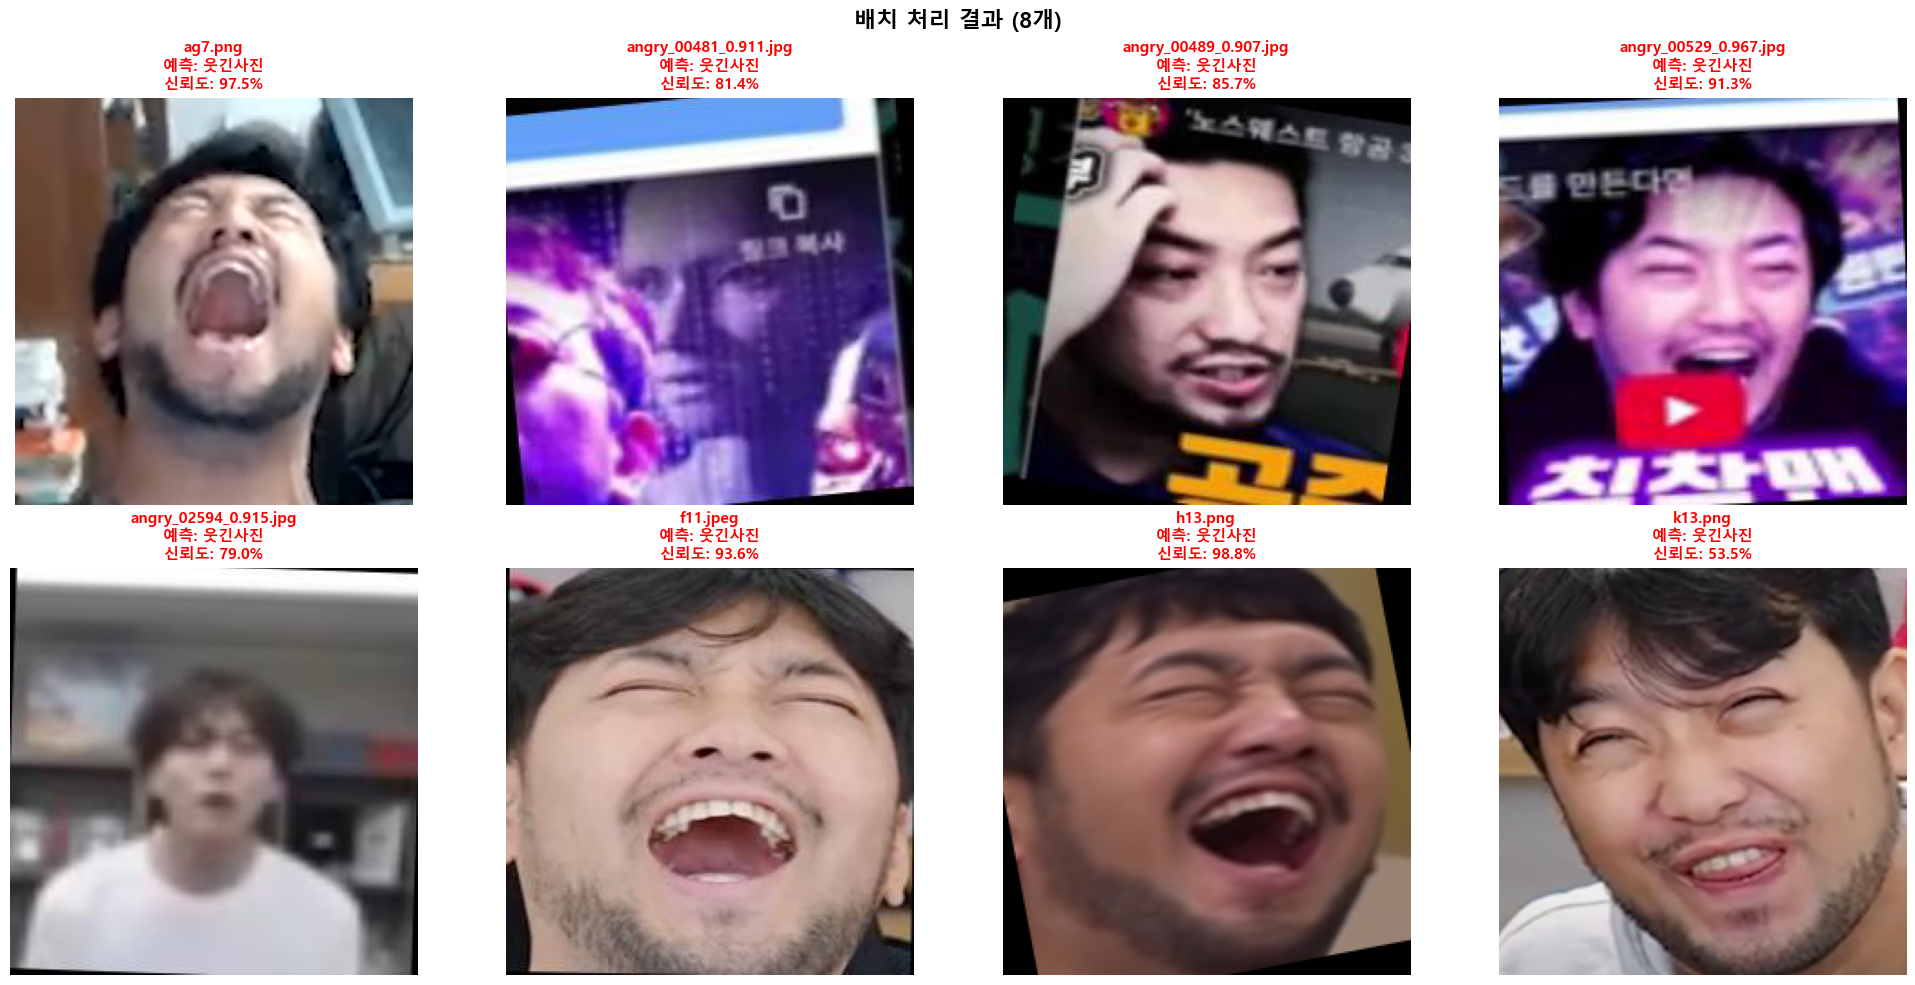


=== 📋 배치 처리 상세 결과 ===
웃긴사진: 15개 (100.0%)
평균 신뢰도: 83.1%
고신뢰도(>80%): 10개
저신뢰도(<60%): 1개


In [9]:

# ============================================
# 셀 8: test_image 디렉토리 테스트 (배치 처리)
# ============================================
print(f"\n=== 🚀 test_image 디렉토리 테스트 (배치 처리) ===")

if test_files:
    # 배치 처리
    batch_size = 32
    image_paths = [os.path.join(test_image_dir, f) for f in test_files]
    
    start_time = datetime.now()
    batch_results = load_and_predict_batch(image_paths, model, test_transform, device, batch_size)
    end_time = datetime.now()
    
    batch_processing_time = (end_time - start_time).total_seconds()
    
    # 유효한 결과만 필터링
    valid_batch_results = []
    for i, (img, pred_class, confidence, probs) in enumerate(batch_results):
        if img is not None:
            valid_batch_results.append({
                'file': test_files[i],
                'prediction': class_names[pred_class],
                'confidence': confidence,
                'probabilities': probs,
                'image': img
            })
    
    print(f"배치 처리 완료!")
    print(f"총 처리 이미지: {len(valid_batch_results)}개")
    print(f"배치 처리 시간: {batch_processing_time:.2f}초")
    print(f"이미지당 평균 시간: {batch_processing_time/len(valid_batch_results):.3f}초")
    
    # 성능 비교 (단일 처리 결과가 있는 경우)
    if 'processing_time' in locals():
        speedup = processing_time / batch_processing_time
        print(f"🚀 배치 처리 속도 향상: {speedup:.1f}배")
    
    # 배치 처리 결과 시각화 (최대 8개)
    display_count = min(8, len(valid_batch_results))
    if display_count > 0:
        cols = 4
        rows = (display_count + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
        fig.suptitle(f'배치 처리 결과 ({display_count}개)', fontsize=16, fontweight='bold')
        
        # axes 처리
        if display_count == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        axes = np.array(axes).flatten()
        
        for idx in range(display_count):
            result = valid_batch_results[idx]
            
            # 이미지 표시
            axes[idx].imshow(result['image'])
            axes[idx].axis('off')
            
            # 예측 결과
            pred_label = result['prediction']
            confidence = result['confidence']
            title_color = colors[0] if pred_label == '비약올리기' else colors[1]
            
            # 제목 설정
            title = f"{result['file']}\n예측: {pred_label}\n신뢰도: {confidence:.1%}"
            axes[idx].set_title(title, fontsize=11, color=title_color, fontweight='bold')
        
        # 빈 subplot 숨기기
        for idx in range(display_count, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # 배치 처리 상세 결과
    print(f"\n=== 📋 배치 처리 상세 결과 ===")
    batch_pred_counts = {}
    for result in valid_batch_results:
        pred = result['prediction']
        batch_pred_counts[pred] = batch_pred_counts.get(pred, 0) + 1
    
    for class_name, count in batch_pred_counts.items():
        percentage = count / len(valid_batch_results) * 100
        print(f"{class_name}: {count}개 ({percentage:.1f}%)")
    
    # 평균 신뢰도
    if valid_batch_results:
        avg_confidence = sum(result['confidence'] for result in valid_batch_results) / len(valid_batch_results)
        print(f"평균 신뢰도: {avg_confidence:.1%}")
        
        # 고신뢰도/저신뢰도 이미지
        high_conf = [r for r in valid_batch_results if r['confidence'] > 0.8]
        low_conf = [r for r in valid_batch_results if r['confidence'] < 0.6]
        print(f"고신뢰도(>80%): {len(high_conf)}개")
        print(f"저신뢰도(<60%): {len(low_conf)}개")


In [ ]:

# ============================================
# 셀 9: 개별 이미지 상세 분석 (선택적)
# ============================================
# 특정 이미지 파일 경로를 지정해서 상세 분석
# 예시: analyze_single_image(r"D:\my_projects\calmman-facial-classification\data\processed\test_image\your_image.jpg")

print("\n=== 🔍 개별 이미지 상세 분석 ===")
print("특정 이미지를 상세 분석하려면 다음 함수를 사용하세요:")
print("analyze_single_image('이미지_경로')")

# 예시로 첫 번째 이미지 분석 (있는 경우)
if test_files:
    first_image_path = os.path.join(test_image_dir, test_files[0])
    print(f"\n첫 번째 이미지 상세 분석: {test_files[0]}")
    analyze_single_image(first_image_path)